In [ ]:
#| default_exp models.tft

# Temporal Fusion Transformers

> In summary Temporal Fusion Transformer (TFT) combines gating layers, an LSTM recurrent encoder, with multi-head attention layers for a multi-step forecasting strategy decoder.<br>TFT's inputs are static exogenous $\mathbf{x}^{(s)}$, historic exogenous $\mathbf{x}^{(h)}_{[:t]}$, exogenous available at the time of the prediction $\mathbf{x}^{(f)}_{[:t+H]}$ and autorregresive features $\mathbf{y}_{[:t]}$, each of these inputs is further decomposed into categorical and continuous. The network uses a multi-quantile regression to model the following conditional probability:$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$<br><br>**References**<br>- [Jan Golda, Krzysztof Kudrynski. "NVIDIA, Deep Learning Forecasting Examples"](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Forecasting/TFT)<br>- [Bryan Lim, Sercan O. Arik, Nicolas Loeff, Tomas Pfister, "Temporal Fusion Transformers for interpretable multi-horizon time series forecasting"](https://www.sciencedirect.com/science/article/pii/S0169207021000637)<br>

![Figure 1. Temporal Fusion Transformer Architecture.](imgs_models/tft_architecture.png)

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LayerNorm

import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

from typing import Tuple, Optional, Iterable, Any

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Auxiliary Functions

### 1.1 Gating Mechanisms

The Gated Residual Network (GRN) provides adaptive depth and network complexity capable of accommodating different size datasets. As residual connections allow for the network to skip the non-linear transformation of input $\mathbf{a}$ and context $\mathbf{c}$.

\begin{align}
\eta_{1} &= \mathrm{ELU}(\mathbf{W}_{1}\mathbf{a}+\mathbf{W}_{2}\mathbf{c}+\mathbf{b}_{1}) \\
\eta_{2} &= \mathbf{W}_{2}\eta_{1}+b_{2} \\
\mathrm{GRN}(\mathbf{a}, \mathbf{c}) &= \mathrm{LayerNorm}(a + \textrm{GLU}(\eta_{2}))
\end{align}

The Gated Linear Unit (GLU) provides the flexibility of supressing unnecesary parts of the GRN. Consider GRN's output $\gamma$ then GLU transformation is defined by:

$$\mathrm{GLU}(\gamma) = \sigma(\mathbf{W}_{4}\gamma +b_{4}) \odot (\mathbf{W}_{5}\gamma +b_{5})$$

![Figure 2. Gated Residual Network.](imgs_models/tft_grn.png)

In [ ]:
#| exporti
class MaybeLayerNorm(nn.Module):
    def __init__(self, output_size, hidden_size, eps):
        super().__init__()
        if output_size and output_size == 1:
            self.ln = nn.Identity()
        else:
            self.ln = LayerNorm(output_size if output_size else hidden_size,
                                eps=eps)

    def forward(self, x):
        return self.ln(x)

class GLU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.lin = nn.Linear(hidden_size, output_size * 2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.lin(x)
        x = F.glu(x)
        return x

class GRN(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size, 
                 output_size=None,
                 context_hidden_size=None,
                 dropout=0):
        super().__init__()
        
        self.layer_norm = MaybeLayerNorm(output_size, hidden_size, eps=1e-3)
        self.lin_a = nn.Linear(input_size, hidden_size)
        if context_hidden_size is not None:
            self.lin_c = nn.Linear(context_hidden_size, hidden_size, bias=False)
        self.lin_i = nn.Linear(hidden_size, hidden_size)
        self.glu = GLU(hidden_size, output_size if output_size else hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(input_size, output_size) if output_size else None

    def forward(self, a: Tensor, c: Optional[Tensor] = None):
        x = self.lin_a(a)
        if c is not None:
            x = x + self.lin_c(c).unsqueeze(1)
        x = F.elu(x)
        x = self.lin_i(x)
        x = self.dropout(x)
        x = self.glu(x)
        y = a if not self.out_proj else self.out_proj(a)
        x = x + y
        x = self.layer_norm(x)
        return x

### 1.2 Variable Selection Networks

TFT includes automated variable selection capabilities, through its variable selection network (VSN) components. The VSN takes the original input $\{\mathbf{x}^{(s)}, \mathbf{x}^{(h)}_{[:t]}, \mathbf{x}^{(f)}_{[:t]}\}$ and transforms it through categorical embeddings or linear transformations into a high dimensional space
$\{\mathbf{E}^{(s)}, \mathbf{E}^{(h)}_{[:t]}, \mathbf{E}^{(f)}_{[:t+H]}\}$. 

For the observed historic data, the embedding matrix $\mathbf{E}^{(h)}_{t}$ at time $t$ is a concatenation of $j$ variable $e^{(h)}_{t,j}$ embeddings:
\begin{align}
\mathbf{E}^{(h)}_{t} &= [e^{(h)}_{t,1},\dots,e^{(h)}_{t,j},\dots,e^{(h)}_{t,n_{h}}] \\
\mathbf{\tilde{e}}^{(h)}_{t,j} &= \mathrm{GRN}(e^{(h)}_{t,j})
\end{align}

The variable selection weights are given by:
$$s^{(h)}_{t}=\mathrm{SoftMax}(\mathrm{GRN}(\mathbf{E}^{(h)}_{t},\mathbf{E}^{(s)}))$$

The VSN processed features are then:
$$\tilde{\mathbf{E}}^{(h)}_{t}= \sum_{j} s^{(h)}_{j} \tilde{e}^{(h)}_{t,j}$$

![Figure 3. Variable Selection Network.](imgs_models/tft_vsn.png)

In [ ]:
#| exporti
class TFTEmbedding(nn.Module):
    def __init__(self, hidden_size,
                 s_cat_inp_lens, s_cont_inp_size,
                 k_cat_inp_lens, k_cont_inp_size,
                 o_cat_inp_lens, o_cont_inp_size,
                 tgt_size):
        super().__init__()
        # There are 7 types of input:
        # 1. Static categorical
        # 2. Static continuous
        # 3. Temporal known a priori categorical
        # 4. Temporal known a priori continuous
        # 5. Temporal observed categorical
        # 6. Temporal observed continuous
        # 7. Temporal observed targets (time series obseved so far)

        self.hidden_size = hidden_size

        self.s_cat_inp_lens  = s_cat_inp_lens
        self.s_cont_inp_size = s_cont_inp_size
        self.k_cat_inp_lens  = k_cat_inp_lens
        self.k_cont_inp_size = k_cont_inp_size
        self.o_cat_inp_lens  = o_cat_inp_lens
        self.o_cont_inp_size = o_cont_inp_size
        self.tgt_size        = tgt_size

        # Instantiate Categorical Embeddings if lens is not None
        for attr, lens in [('s_cat_embed', s_cat_inp_lens), 
                           ('k_cat_embed', k_cat_inp_lens),
                           ('o_cat_embed', o_cat_inp_lens)]:
            if lens:
                embed = nn.ModuleList([nn.Embedding(n, hidden_size) for n in lens])
                setattr(self, attr, embed)
            else:
                setattr(self, attr, None)

        # Instantiate Continuous Embeddings if size is not None
        for attr, size in [('s_cont_embedding', s_cont_inp_size), 
                           ('k_cont_embedding', k_cont_inp_size),
                           ('o_cont_embedding', o_cont_inp_size),
                           ('tgt_embedding', tgt_size)]:
            if size:
                vectors = nn.Parameter(torch.Tensor(size, hidden_size))
                bias = nn.Parameter(torch.zeros(size, hidden_size))
                torch.nn.init.xavier_normal_(vectors)
                setattr(self, attr+'_vectors', vectors)
                setattr(self, attr+'_bias', bias)
            else:
                setattr(self, attr+'_vectors', None)
                setattr(self, attr+'_bias', None)

    def _apply_embedding(self,
                         cat: Optional[Tensor],
                         cont: Optional[Tensor],
                         cat_emb: Iterable[Any], 
                         cont_emb: Tensor,
                         cont_bias: Tensor,
                         ):

        if (cat is None) and (cont is None):
            return None

        if (cat is not None):
            e_cat = torch.stack([embed(cat[...,i]) \
                               for i, embed in enumerate(cat_emb)], dim=-2)
        if (cont is not None):
            #the line below is equivalent to following einsums
            #e_cont = torch.einsum('btf,fh->bthf', cont, cont_emb)
            #e_cont = torch.einsum('bf,fh->bhf', cont, cont_emb)          
            e_cont = torch.mul(cont.unsqueeze(-1), cont_emb)
            e_cont = e_cont + cont_bias

        if (cat is not None) and (cont is None):
            return e_cat

        if (cat is None) and (cont is not None):
            return e_cont

        if (cat is not None) and (cont is not None):
            return torch.cat([e_cat, e_cont], dim=-2)
        
        return None

    def forward(self, target_inp, s_cat_inp=None, s_cont_inp=None, k_cat_inp=None, k_cont_inp=None, o_cat_inp=None, o_cont_inp=None):
        # temporal/static categorical/continuous known/observed input 
        # tries to get input, if fails returns None

        # Static inputs are expected to be equal for all timesteps
        # For memory efficiency there is no assert statement
        s_cat_inp = s_cat_inp[:,0,:] if s_cat_inp is not None else None
        s_cont_inp = s_cont_inp[:,0,:] if s_cont_inp is not None else None

        s_inp = self._apply_embedding(s_cat_inp, s_cont_inp,
                                      cat_emb=self.s_cat_embed,
                                      cont_emb=self.s_cont_embedding_vectors,
                                      cont_bias=self.s_cont_embedding_bias)
        k_inp = self._apply_embedding(k_cat_inp, k_cont_inp,
                                      cat_emb=self.k_cat_embed,
                                      cont_emb=self.k_cont_embedding_vectors,
                                      cont_bias=self.k_cont_embedding_bias)
        o_inp = self._apply_embedding(o_cat_inp, o_cont_inp,
                                      cat_emb=self.o_cat_embed,
                                      cont_emb=self.o_cont_embedding_vectors,
                                      cont_bias=self.o_cont_embedding_bias)

        # Temporal observed targets
        # t_observed_tgt = torch.einsum('btf,fh->btfh', 
        #                               target_inp, self.tgt_embedding_vectors)        
        target_inp = torch.matmul(target_inp.unsqueeze(3).unsqueeze(4),
                          self.tgt_embedding_vectors.unsqueeze(1)).squeeze(3)
        target_inp = target_inp + self.tgt_embedding_bias

        return s_inp, k_inp, o_inp, target_inp

class VariableSelectionNetwork(nn.Module):
    def __init__(self, hidden_size, num_inputs, dropout):
        super().__init__()
        self.joint_grn = GRN(input_size=hidden_size*num_inputs, 
                             hidden_size=hidden_size, 
                             output_size=num_inputs, 
                             context_hidden_size=hidden_size)
        self.var_grns = nn.ModuleList(
                        [GRN(input_size=hidden_size, 
                             hidden_size=hidden_size, dropout=dropout)
                         for _ in range(num_inputs)])

    def forward(self, x: Tensor, context: Optional[Tensor] = None):
        Xi = x.reshape(*x.shape[:-2], -1)
        grn_outputs = self.joint_grn(Xi, c=context)
        sparse_weights = F.softmax(grn_outputs, dim=-1)
        transformed_embed_list = [m(x[...,i,:])
                                     for i, m in enumerate(self.var_grns)]
        transformed_embed = torch.stack(transformed_embed_list, dim=-1)
        #the line below performs batched matrix vector multiplication
        #for temporal features it's bthf,btf->bth
        #for static features it's bhf,bf->bh
        variable_ctx = torch.matmul(transformed_embed, 
                                    sparse_weights.unsqueeze(-1)).squeeze(-1)

        return variable_ctx, sparse_weights

### 1.3. Multi-Head Attention

To avoid information bottlenecks from the classic Seq2Seq architecture, TFT 
incorporates a decoder-encoder attention mechanism inherited transformer architectures ([Li et. al 2019](https://arxiv.org/abs/1907.00235), [Vaswani et. al 2017](https://arxiv.org/abs/1706.03762)). It transform the the outputs of the LSTM encoded temporal features, and helps the decoder better capture long-term relationships.

The original multihead attention for each component $H_{m}$ and its query, key, and value representations are denoted by $Q_{m}, K_{m}, V_{m}$, its transformation is given by:

\begin{align}
Q_{m} = Q W_{Q,m} \quad K_{m} = K W_{K,h} \quad V_{m} = V W_{V,m} \\
H_{m}=\mathrm{Attention}(Q_{m}, K_{m}, V_{m}) = \mathrm{SoftMax}(Q_{m} K^{\intercal}_{m}/\mathrm{scale}) \; V_{m} \\
\mathrm{MultiHead}(Q, K, V) = [H_{1},\dots,H_{M}] W_{M}
\end{align}

TFT modifies the original multihead attention to improve its interpretability. To do it it uses shared values $\tilde{V}$ across heads and employs additive aggregation, $\mathrm{InterpretableMultiHead}(Q,K,V) = \tilde{H} W_{M}$. The mechanism has a great resemblence to a single attention layer, but it allows for $M$ multiple attention weights, and can be therefore be interpreted as the average ensemble of $M$ single attention layers.

\begin{align}
\tilde{H} &= \left(\frac{1}{M} \sum_{m} \mathrm{SoftMax}(Q_{m} K^{\intercal}_{m}/\mathrm{scale}) \right) \tilde{V} 
          = \frac{1}{M} \sum_{m} \mathrm{Attention}(Q_{m}, K_{m}, \tilde{V}) \\
\end{align}

In [ ]:
#| exporti
class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, n_head, hidden_size, example_length,
                 attn_dropout, dropout):
        super().__init__()
        self.n_head = n_head
        assert hidden_size % n_head == 0
        self.d_head = hidden_size // n_head
        self.qkv_linears = nn.Linear(hidden_size, 
                                     (2 * self.n_head + 1) * self.d_head,
                                     bias=False)
        self.out_proj = nn.Linear(self.d_head, hidden_size, bias=False)

        self.attn_dropout = nn.Dropout(attn_dropout)
        self.out_dropout = nn.Dropout(dropout)
        self.scale = self.d_head**-0.5
        self.register_buffer("_mask",
          torch.triu(torch.full((example_length, example_length), 
                                float('-inf')), 1).unsqueeze(0))

    def forward(self, x: Tensor, 
                mask_future_timesteps: bool = True) -> Tuple[Tensor, Tensor]:
        # [Batch,Time,MultiHead,AttDim] := [N,T,M,AD]
        bs, t, h_size = x.shape
        qkv = self.qkv_linears(x)
        q, k, v = qkv.split((self.n_head * self.d_head, 
                             self.n_head * self.d_head, self.d_head), dim=-1)
        q = q.view(bs, t, self.n_head, self.d_head)
        k = k.view(bs, t, self.n_head, self.d_head)
        v = v.view(bs, t, self.d_head)
        
        # [N,T1,M,Ad] x [N,T2,M,Ad] -> [N,M,T1,T2]
        # attn_score = torch.einsum('bind,bjnd->bnij', q, k)
        attn_score = torch.matmul(q.permute((0, 2, 1, 3)), 
                                  k.permute((0, 2, 3, 1)))
        attn_score.mul_(self.scale)

        if mask_future_timesteps:
            attn_score = attn_score + self._mask

        attn_prob = F.softmax(attn_score, dim=3)
        attn_prob = self.attn_dropout(attn_prob)

        # [N,M,T1,T2] x [N,M,T1,Ad] -> [N,M,T1,Ad]
        # attn_vec = torch.einsum('bnij,bjd->bnid', attn_prob, v)
        attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
        m_attn_vec = torch.mean(attn_vec, dim=1)
        out = self.out_proj(m_attn_vec)
        out = self.out_dropout(out)

        return out, attn_vec

## 2. TFT Architecture

The first TFT's step is embed the original input $\{\mathbf{x}^{(s)}, \mathbf{x}^{(h)}, \mathbf{x}^{(f)}\}$ into a high dimensional space $\{\mathbf{E}^{(s)}, \mathbf{E}^{(h)}, \mathbf{E}^{(f)}\}$, after which each embedding is gated by a variable selection network (VSN). The static embedding $\mathbf{E}^{(s)}$ is used as context for variable selection and as initial condition to the LSTM. Finally the encoded variables are fed into the multi-head attention decoder.

\begin{align}
 c_{s}, c_{e}, (c_{h}, c_{c}) &=\textrm{StaticCovariateEncoder}(\mathbf{E}^{(s)}) \\ 
      h_{[:t]}, h_{[t+1:t+H]}  &=\textrm{TemporalCovariateEncoder}(\mathbf{E}^{(h)}, \mathbf{E}^{(f)}, c_{h}, c_{c}) \\
\hat{\mathbf{y}}^{(q)}_{[t+1:t+H]} &=\textrm{TemporalFusionDecoder}(h_{[t+1:t+H]}, c_{e})
\end{align}

### 2.1 Static Covariate Encoder

The static embedding $\mathbf{E}^{(s)}$ is transformed by the StaticCovariateEncoder into contexts $c_{s}, c_{e}, c_{h}, c_{c}$. Where $c_{s}$ are temporal variable selection contexts, $c_{e}$ are TemporalFusionDecoder enriching contexts, and $c_{h}, c_{c}$ are LSTM's hidden/contexts for the TemporalCovariateEncoder.

\begin{align}
c_{s}, c_{e}, (c_{h}, c_{c}) & = \textrm{GRN}(\textrm{VSN}(\mathbf{E}^{(s)}))
\end{align}

In [ ]:
#| exporti
class StaticCovariateEncoder(nn.Module):
    def __init__(self, hidden_size, num_static_vars, dropout):
        super().__init__()
        self.vsn = VariableSelectionNetwork(hidden_size=hidden_size,
                                            num_inputs=num_static_vars,
                                            dropout=dropout)
        self.context_grns = nn.ModuleList(
                              [GRN(input_size=hidden_size,
                                   hidden_size=hidden_size,
                                   dropout=dropout) for _ in range(4)])

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        variable_ctx, sparse_weights = self.vsn(x)

        # Context vectors:
        # variable selection context
        # enrichment context
        # state_c context
        # state_h context
        cs, ce, ch, cc = tuple(m(variable_ctx) for m in self.context_grns)

        return cs, ce, ch, cc

### 2.2 Temporal Covariate Encoder

TemporalCovariateEncoder encodes the embeddings $\mathbf{E}^{(h)}, \mathbf{E}^{(f)}$ and contexts  $(c_{h}, c_{c})$ with an LSTM.

\begin{align}
\tilde{\mathbf{E}}^{(h)}_{[:t]} & = \textrm{VSN}(\mathbf{E}^{(h)}_{[:t]}, c_{s}) \\
\tilde{\mathbf{E}}^{(h)}_{[:t]} &= \mathrm{LSTM}(\tilde{\mathbf{E}}^{(h)}_{[:t]}, (c_{h}, c_{c})) \\
h_{[:t]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\tilde{\mathbf{E}}^{(h)}_{[:t]}))
\end{align}

An analogous process is repeated for the future data, with the main difference that $\mathbf{E}^{(f)}$ contains the future available information.

\begin{align}
\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]} & = \textrm{VSN}(\mathbf{E}^{(h)}_{t+1:t+H}, \mathbf{E}^{(f)}_{t+1:t+H}, c_{s}) \\
\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]} &= \mathrm{LSTM}(\tilde{\mathbf{E}}^{(h)}_{[t+1:t+h]}, (c_{h}, c_{c})) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]}))
\end{align}

In [ ]:
#| exporti
class TemporalCovariateEncoder(nn.Module):
    def __init__(self, hidden_size, 
                 num_historic_vars, num_future_vars, dropout):
        super(TemporalCovariateEncoder, self).__init__()

        self.history_vsn = VariableSelectionNetwork(
                                       hidden_size=hidden_size,
                                       num_inputs=num_historic_vars,
                                       dropout=dropout)
        self.history_encoder = nn.LSTM(input_size=hidden_size,
                                       hidden_size=hidden_size,
                                       batch_first=True)
        
        self.future_vsn = VariableSelectionNetwork(hidden_size=hidden_size,
                                                   num_inputs=num_future_vars,
                                                   dropout=dropout)
        self.future_encoder = nn.LSTM(input_size=hidden_size,
                                      hidden_size=hidden_size,
                                      batch_first=True)
        
        # Shared Gated-Skip Connection
        self.input_gate = GLU(hidden_size, hidden_size)
        self.input_gate_ln = LayerNorm(hidden_size, eps=1e-3)
    
    def forward(self, historical_inputs, future_inputs, cs, ch, cc):
        # [N,X_in,L] -> [N,hidden_size,L]
        historical_features, _ = self.history_vsn(historical_inputs, cs)
        history, state = self.history_encoder(historical_features, (ch, cc))

        future_features, _ = self.future_vsn(future_inputs, cs)
        future, _ = self.future_encoder(future_features, state)
        #torch.cuda.synchronize() # this call gives prf boost for unknown reasons

        input_embedding = torch.cat([historical_features, future_features], dim=1)
        temporal_features = torch.cat([history, future], dim=1)
        temporal_features = self.input_gate(temporal_features)
        temporal_features = temporal_features + input_embedding
        temporal_features = self.input_gate_ln(temporal_features)      
        return temporal_features

### 2.3 Temporal Fusion Decoder

The TemporalFusionDecoder enriches the LSTM's outputs with $c_{e}$ and then uses an attention layer, and multi-step adapter.
\begin{align}
h_{[t+1:t+H]} &= \mathrm{MultiHeadAttention}(h_{[:t]}, h_{[t+1:t+H]}, c_{e}) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(h_{[t+1:t+H]}) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\mathrm{GRN}(h_{[t+1:t+H]})) \\
\hat{\mathbf{y}}^{(q)}_{[t+1:t+H]} &= \mathrm{MLP}(h_{[t+1:t+H]})
\end{align}

In [ ]:
#| exporti
class TemporalFusionDecoder(nn.Module):
    def __init__(self, 
                 n_head, hidden_size, 
                 example_length, encoder_length,
                 attn_dropout, dropout):
        super(TemporalFusionDecoder, self).__init__()
        self.encoder_length = encoder_length
        
        #------------- Encoder-Decoder Attention --------------#
        self.enrichment_grn = GRN(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  context_hidden_size=hidden_size, 
                                  dropout=dropout)
        self.attention = InterpretableMultiHeadAttention(
                                       n_head=n_head,
                                       hidden_size=hidden_size,
                                       example_length=example_length,
                                       attn_dropout=attn_dropout,
                                       dropout=dropout)
        self.attention_gate = GLU(hidden_size, hidden_size)
        self.attention_ln = LayerNorm(normalized_shape=hidden_size, eps=1e-3)

        self.positionwise_grn = GRN(input_size=hidden_size,
                                    hidden_size=hidden_size,
                                    dropout=dropout)
        
        #---------------------- Decoder -----------------------#
        self.decoder_gate = GLU(hidden_size, hidden_size)
        self.decoder_ln = LayerNorm(normalized_shape=hidden_size, eps=1e-3)
        
    
    def forward(self, temporal_features, ce):
        #------------- Encoder-Decoder Attention --------------#
        # Static enrichment
        enriched = self.enrichment_grn(temporal_features, c=ce)

        # Temporal self attention
        x, _ = self.attention(enriched, mask_future_timesteps=True)

        # Don't compute hictorical quantiles
        x = x[:, self.encoder_length:, :]
        temporal_features = temporal_features[:, self.encoder_length:, :]
        enriched = enriched[:, self.encoder_length:, :]

        x = self.attention_gate(x)
        x = x + enriched
        x = self.attention_ln(x)

        # Position-wise feed-forward
        x = self.positionwise_grn(x)

        #---------------------- Decoder ----------------------#
        # Final skip connection
        x = self.decoder_gate(x)
        x = x + temporal_features
        x = self.decoder_ln(x)

        return x

## 3. TFT methods

In [ ]:
#| export
class TFT(BaseWindows):

    def __init__(self,
                 input_size,
                 h,
                 tgt_size=1,
                 hidden_size=128,
                 s_cont_cols=None,
                 s_cat_cols=None,
                 o_cont_cols=None,
                 o_cat_cols=None,
                 k_cont_cols=None,
                 k_cat_cols=None,
                 s_cat_inp_lens=None,
                 s_cont_inp_size=0,
                 k_cat_inp_lens=None,
                 k_cont_inp_size=1,
                 o_cat_inp_lens=None,
                 o_cont_inp_size=0,
                 n_head=4,
                 attn_dropout=0.0,
                 dropout=0.1,
                 windows_batch_size=1024,
                 step_size=1,
                 learning_rate=1e-3,
                 scaler_type='robust',
                 loss=MAE(),
                 batch_size=32, 
                 num_workers_loader=0,
                 drop_last_loader=False,
                 random_seed=1,
                 **trainer_kwargs
                 ):

        # Inherit BaseWindows class
        super(TFT, self).__init__(h=h,
                                  loss=loss,
                                  batch_size=batch_size,
                                  scaler_type=scaler_type,
                                  num_workers_loader=num_workers_loader,
                                  drop_last_loader=drop_last_loader,
                                  random_seed=random_seed,
                                  **trainer_kwargs)

        self.windows_batch_size = windows_batch_size
        self.step_size = step_size
        self.learning_rate = learning_rate

        self.input_size = input_size
        self.example_length = input_size + h

        # Parse lists hyperparameters
        self.s_cont_cols = [] if s_cont_cols is None else s_cont_cols
        self.s_cat_cols = [] if s_cat_cols is None else s_cat_cols
        self.o_cont_cols = [] if o_cont_cols is None else o_cont_cols
        self.o_cat_cols = [] if o_cat_cols is None else o_cat_cols
        self.k_cont_cols = [] if k_cont_cols is None else k_cont_cols
        self.k_cat_cols = [] if k_cat_cols is None else k_cat_cols

        s_cat_inp_lens = [] if s_cat_inp_lens is None else s_cat_inp_lens
        k_cat_inp_lens = [] if k_cat_inp_lens is None else k_cat_inp_lens
        o_cat_inp_lens = [] if o_cat_inp_lens is None else o_cat_inp_lens

        num_static_vars = s_cont_inp_size + len(s_cat_inp_lens)
        num_future_vars = k_cont_inp_size + len(k_cat_inp_lens)
        num_observ_vars = o_cont_inp_size + len(o_cat_inp_lens)
        num_historic_vars = num_future_vars + num_observ_vars + tgt_size

        #------------------------------- Encoders -----------------------------#
        self.embedding = TFTEmbedding(hidden_size=hidden_size,
                                      s_cat_inp_lens=s_cat_inp_lens,
                                      s_cont_inp_size=s_cont_inp_size,
                                      k_cat_inp_lens=k_cat_inp_lens, 
                                      k_cont_inp_size=k_cont_inp_size,
                                      o_cat_inp_lens=o_cat_inp_lens,
                                      o_cont_inp_size=o_cont_inp_size,
                                      tgt_size=tgt_size)
        
        self.static_encoder = StaticCovariateEncoder(
                                      hidden_size=hidden_size,
                                      num_static_vars=num_static_vars,
                                      dropout=dropout)

        self.temporal_encoder = TemporalCovariateEncoder(
                                      hidden_size=hidden_size,
                                      num_historic_vars=num_historic_vars,
                                      num_future_vars=num_future_vars,
                                      dropout=dropout)

        #------------------------------ Decoders -----------------------------#
        self.temporal_fusion_decoder = TemporalFusionDecoder(
                                      n_head=n_head,
                                      hidden_size=hidden_size,
                                      example_length=self.example_length,
                                      encoder_length=self.input_size,
                                      attn_dropout=attn_dropout,
                                      dropout=dropout)

        # Adapter with Loss dependent dimensions
        self.output_adapter = nn.Linear(in_features=hidden_size,
                                 out_features=self.loss.outputsize_multiplier)

    def forward(self, x):

        # Extract static and temporal features
        y_idx = x['temporal_cols'].get_loc('y')
        target_inp = x['temporal'][:, :, y_idx, None]

        if len(self.k_cont_cols) > 0:
            k_cont_inp = x['temporal'][:, :, x['temporal_cols'].get_indexer(self.k_cont_cols)]
        else:
            k_cont_inp = x['temporal'][:, [-self.h-1], y_idx]
            k_cont_inp = k_cont_inp[:,:,None].repeat(1, self.example_length, 1)

        # TODO: improve dictionary unpacking
        s_inp, k_inp, o_inp, t_observed_tgt = self.embedding(target_inp=target_inp,
                                                             k_cont_inp=k_cont_inp)

        #-------------------------------- Inputs ------------------------------#
        # Static context
        if s_inp is not None:
            cs, ce, ch, cc = self.static_encoder(s_inp)
            ch, cc = ch.unsqueeze(0), cc.unsqueeze(0) # LSTM initial states
        else:
            # If None add zeros
            batch_size, example_length, target_size, hidden_size = t_observed_tgt.shape
            cs = torch.zeros(size=(batch_size, hidden_size)).to(target_inp.device)
            ce = torch.zeros(size=(batch_size, hidden_size)).to(target_inp.device)
            ch = torch.zeros(size=(1, batch_size, hidden_size)).to(target_inp.device)
            cc = torch.zeros(size=(1, batch_size, hidden_size)).to(target_inp.device)

        # Historical inputs
        _historical_inputs = [k_inp[:,:self.input_size,:],
                              t_observed_tgt[:,:self.input_size,:]]
        if o_inp is not None:
            _historical_inputs.insert(0,o_inp[:,:self.input_size,:])
        historical_inputs = torch.cat(_historical_inputs, dim=-2)

        # Future inputs
        future_inputs = k_inp[:, self.input_size:]

        #---------------------------- Encode/Decode ---------------------------#
        # Embeddings + VSN + LSTM encoders
        temporal_features = self.temporal_encoder(historical_inputs,
                                                  future_inputs,
                                                  cs, ch, cc)

        # Static enrichment, Attention and decoders
        temporal_features = self.temporal_fusion_decoder(temporal_features, ce)

        # Adapt output to loss
        y_hat = self.output_adapter(temporal_features)
        if self.loss.outputsize_multiplier==1:
            y_hat = y_hat.squeeze(-1)

        return y_hat
    
    def training_step(self, batch, batch_idx):
        # Deviates from orignal `BaseWindows.training_step` to 
        # allow the model to receive future exogenous available
        # at the time of the prediction.
        
        # Create windows [Ws, L+H, C]
        windows = self._create_windows(batch, step='train')

        # Normalize windows
        if self.scaler is not None:
            windows = self._normalization(windows=windows)

        # outsample
        y_idx = batch['temporal_cols'].get_loc('y')
        mask_idx = batch['temporal_cols'].get_loc('available_mask')
        outsample_y = windows['temporal'][:, -self.h:, y_idx]
        outsample_mask = windows['temporal'][:, -self.h:, mask_idx]

        #batch_size, input_size
        y_hat = self(x=windows)

        loss = self.loss(y=outsample_y, y_hat=y_hat, mask=outsample_mask)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        # Deviates from orignal `BaseWindows.training_step` to 
        # allow the model to receive future exogenous available
        # at the time of the prediction.        
        
        # Create windows [Ws, L+H, C]
        windows = self._create_windows(batch, step='predict')

        # Normalize windows
        if self.scaler is not None:
            windows = self._normalization(windows=windows)

        y_hat = self(x=windows)

        # Inv Normalize
        if self.scaler is not None:
            y_hat = self._inv_normalization(y_hat=y_hat,
                                            temporal_cols=batch['temporal_cols'])

        return y_hat

In [ ]:
show_doc(TFT, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/tree/main/blob/main/neuralforecast/models/tft.py#L397){target="_blank" style="float:right; font-size:smaller"}

### TFT

>      TFT (input_size, h, tgt_size=1, hidden_size=128, s_cont_cols=None,
>           s_cat_cols=None, o_cont_cols=None, o_cat_cols=None,
>           k_cont_cols=None, k_cat_cols=None, s_cat_inp_lens=None,
>           s_cont_inp_size=0, k_cat_inp_lens=None, k_cont_inp_size=1,
>           o_cat_inp_lens=None, o_cont_inp_size=0, n_head=4, attn_dropout=0.0,
>           dropout=0.1, windows_batch_size=1024, step_size=1,
>           learning_rate=0.001, scaler_type='robust',
>           loss=<neuralforecast.losses.pytorch.MAE object>,
>           batch_size=32, num_workers_loader=0, drop_last_loader=False,
>           random_seed=1, **trainer_kwargs)

Hooks to be used in LightningModule.

In [ ]:
show_doc(TFT.fit, name='TFT.fit', title_level=3)

---

### TFT.fit

>      TFT.fit (dataset, val_size=0, test_size=0)

Fits Model.

**Parameters:**<br>
`dataset`: TimeSeriesDataset.<br>
`trainer`: pl.Trainer.<br>
`val_size`: int, validation size.<br>
`test_size`: int, test size.<br>
`data_kwargs`: extra arguments to be passed to TimeSeriesDataModule.

In [ ]:
show_doc(TFT.predict, name='TFT.predict', title_level=3)

---

### TFT.predict

>      TFT.predict (dataset, test_size=None, step_size=1, **data_kwargs)

Predicts Model.

**Parameters:**<br>
`dataset`: TimeSeriesDataset.<br>
`trainer`: pl.Trainer.<br>
`step_size`: int, Step size between each window.<br>
`data_kwargs`: extra arguments to be passed to TimeSeriesDataModule.

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [ ]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengers, AirPassengersPanel
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

from neuralforecast.losses.pytorch import MQLoss

In [ ]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]] # 12 test

dataset, *_ = TimeSeriesDataset.from_df(df = AirPassengersPanel)
model = TFT(input_size=48, h=12,
            hidden_size=100,
            k_cont_cols=['trend'], #['trend', 'y_[lag12]'],
            k_cont_inp_size=2,
            max_epochs=1,
            learning_rate=0.01,
            scaler_type='robust',
            loss=MQLoss(level=[80, 90]),
            windows_batch_size=None,
            enable_progress_bar=True)

model.fit(dataset=dataset, test_size=12)

# Parse quantile predictions
y_hat = model.predict(dataset=dataset)
Y_hat_df = pd.DataFrame.from_records(data=y_hat,
                columns=['TFT'+q for q in model.loss.output_names],
                index=Y_test_df.index)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

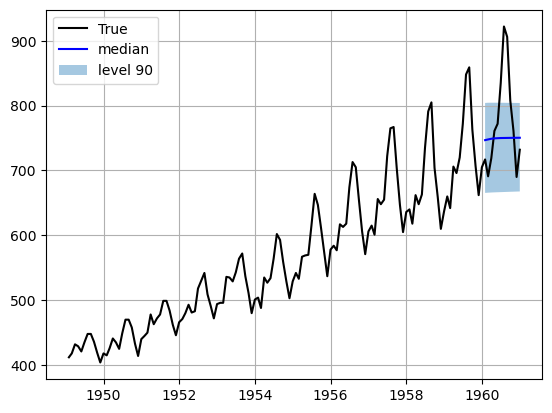

In [ ]:
# Plot quantile predictions
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = plot_df[plot_df.unique_id=='Airline2']
plot_df = pd.concat([Y_train_df, plot_df])
plot_df = plot_df[plot_df.unique_id=='Airline2'].drop('unique_id', axis=1)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['ds'], plot_df['TFT'], c='blue', label='median')
plt.plot(plot_df['ds'], plot_df['TFT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'], 
                 y1=plot_df['TFT-lo-90'], y2=plot_df['TFT-hi-90'],
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()